# 20230925_Xenium_cold_hot_analysis
影山先生が抽出した遺伝子の発現量を比較する。

In [1]:
cd /Volumes/Project/home/sakai/20220404_MONSTAR/data

/Volumes/Project/home/sakai/20220404_MONSTAR/data


In [6]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import stlearn as st

def calculate_q(p_seq):
    p_arr   = np.asarray(p_seq)
    N       = len(p_arr)
    idx_arr = np.argsort(p_arr)
    q_arr   = p_arr[idx_arr] * N / (np.arange(N) + 1)
    q_arr   = np.minimum.accumulate(q_arr[::-1])[::-1]
    q_arr[idx_arr] = q_arr.copy()
    return q_arr

# load xenium case7 after immune panel
# load data of case 7 of immune panel
xenium_case7_post_immune_panel_path = "/Volumes/Project/home/sakai/scRNA/20230518_Xenium/DATA/Xenium_Outputs/20230821__074259__2_019/Xenium_Outputs/output-XETG00053__0006778__15_NSCLC_Case7__20230821__075703/"
adata_xenium_case7_post_immune_panel = st.ReadXenium(
    feature_cell_matrix_file=f"{xenium_case7_post_immune_panel_path}cell_feature_matrix.h5",
    cell_summary_file=f"{xenium_case7_post_immune_panel_path}cells.csv.gz",
    library_id="Xenium_case7_post_lung_panel",
    image_path="/Volumes/Project/home/sakai/sample.jpg",
    scale=1,
    spot_diameter_fullres=15 # Recommend
)

df_xenium = adata_xenium_case7_post_immune_panel.to_df()

df_cell = pd.read_csv(
        f"{xenium_case7_post_immune_panel_path}cells.csv.gz", 
        index_col="cell_id"
)

#df_dens = pd.DataFrame(df_xenium.sum() / df_cell_post.cell_area.sum(), columns=["Density $(count/μm^2)$"])

df_hot1 = pd.read_table("20231012_hot_cold/hot1.txt").groupby("Cluster").get_group("Cluster 11")
df_hot2 = pd.read_table("20231012_hot_cold/hot2.txt").groupby("Cluster").get_group("Cluster 11")
df_hot3 = pd.read_table("20231012_hot_cold/hot3.txt").groupby("Cluster").get_group("Cluster 11")
df_hot4 = pd.read_table("20231012_hot_cold/hot4.txt").groupby("Cluster").get_group("Cluster 11")
df_hot5 = pd.read_table("20231012_hot_cold/hot5.txt").groupby("Cluster").get_group("Cluster 11")
df_hot6 = pd.read_table("20231012_hot_cold/hot6.txt").groupby("Cluster").get_group("Cluster 11")
df_hot7 = pd.read_table("20231012_hot_cold/hot7.txt").groupby("Cluster").get_group("Cluster 11")

df_cold1 = pd.read_table("20231012_hot_cold/cold1.txt").groupby("Cluster").get_group("Cluster 11")
df_cold2 = pd.read_table("20231012_hot_cold/cold2.txt").groupby("Cluster").get_group("Cluster 11")
df_cold3 = pd.read_table("20231012_hot_cold/cold3.txt").groupby("Cluster").get_group("Cluster 11")
df_cold4 = pd.read_table("20231012_hot_cold/cold4.txt").groupby("Cluster").get_group("Cluster 11")
df_cold5 = pd.read_table("20231012_hot_cold/cold5.txt").groupby("Cluster").get_group("Cluster 11")
df_cold6 = pd.read_table("20231012_hot_cold/cold6.txt").groupby("Cluster").get_group("Cluster 11")
df_cold7 = pd.read_table("20231012_hot_cold/cold7.txt").groupby("Cluster").get_group("Cluster 11")


Added tissue image to the object!


In [7]:
# list 
hot_ls = [df_hot1, df_hot2, df_hot3, df_hot4, df_hot5, df_hot6, df_hot7]
cold_ls = [df_cold1, df_cold2, df_cold3, df_cold4, df_cold5, df_cold6, df_cold7]


In [8]:
df_hot = pd.concat(hot_ls, axis=0)
df_cold = pd.concat(cold_ls, axis=0)

In [9]:
# calculate density of each spot
df_dens_hot = pd.DataFrame()

for i in df_hot["Cell ID"]:

    df_temp = pd.DataFrame(
        df_xenium.loc[i] / df_cell.loc[i].cell_area, 
        columns=[i]
    )

    df_dens_hot = pd.concat([df_dens_hot, df_temp], axis=1)

# calculate density of each spot
df_dens_cold = pd.DataFrame()

for i in df_cold["Cell ID"]:

    df_temp = pd.DataFrame(
        df_xenium.loc[i] / df_cell.loc[i].cell_area, 
        columns=[i]
    )

    df_dens_cold = pd.concat([df_dens_cold, df_temp], axis=1)

# concat
df_hot_cold = pd.concat([df_dens_hot, df_dens_cold], axis=1)

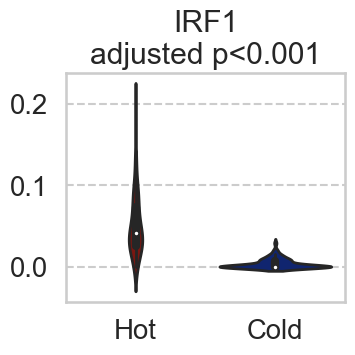

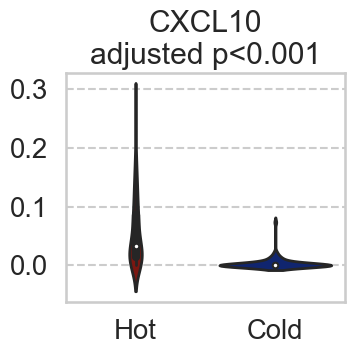

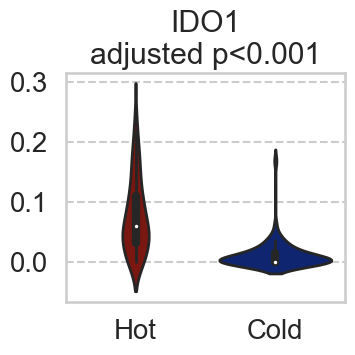

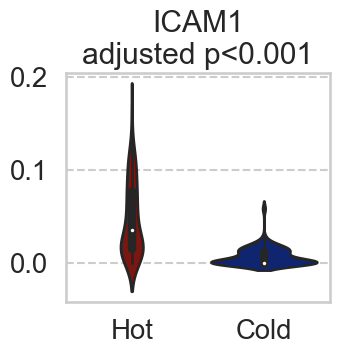

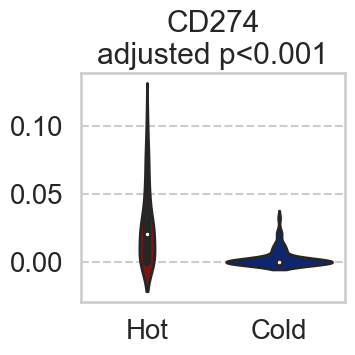

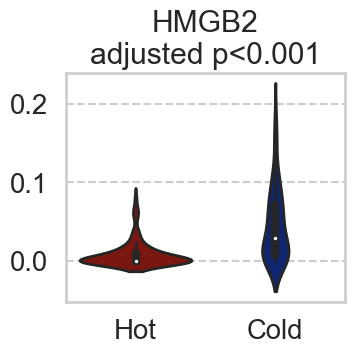

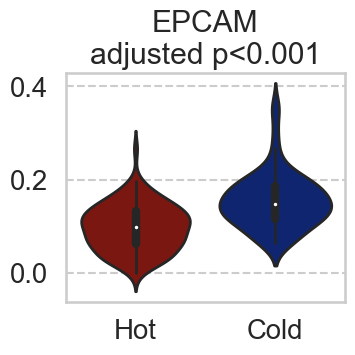

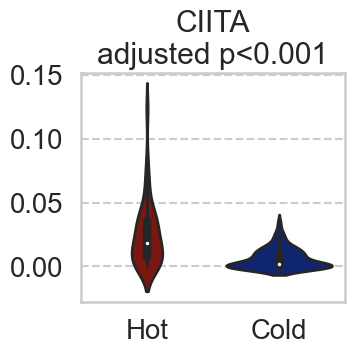

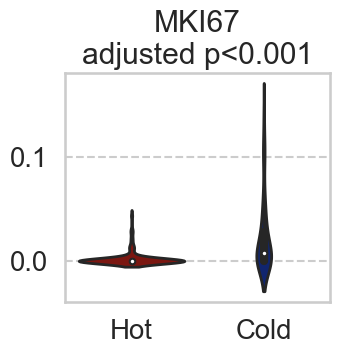

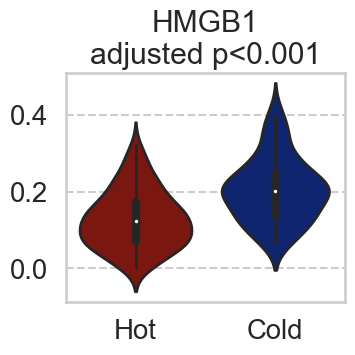

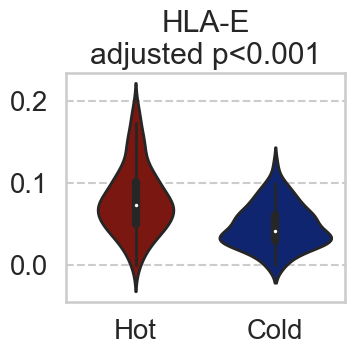

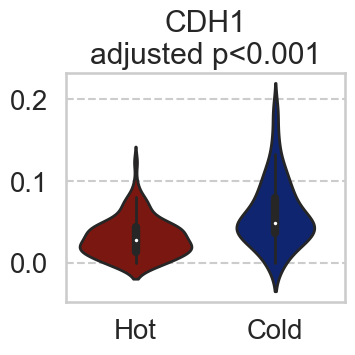

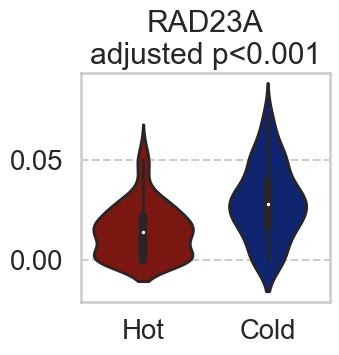

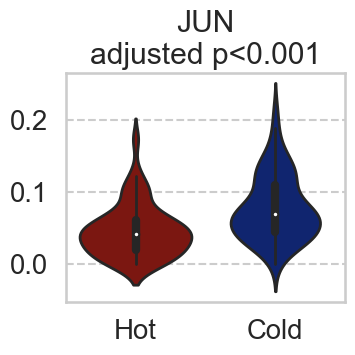

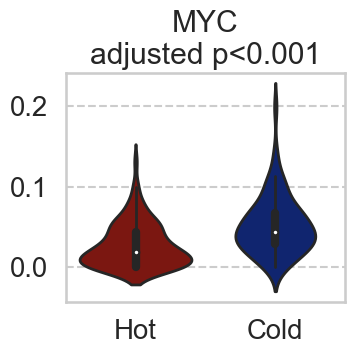

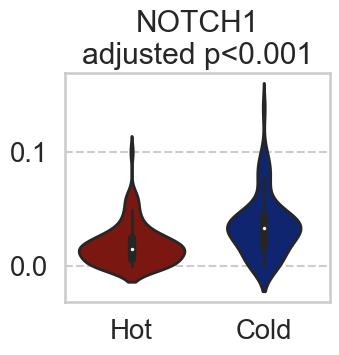

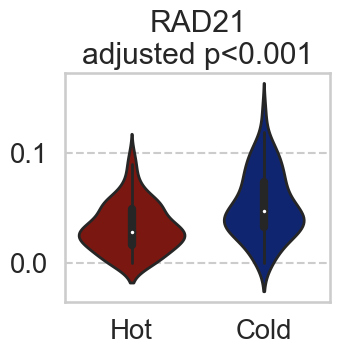

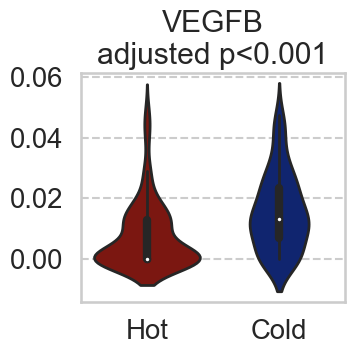

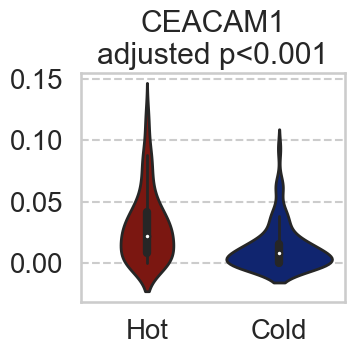

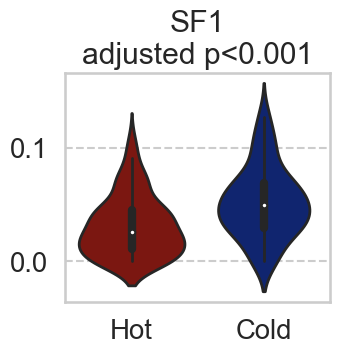

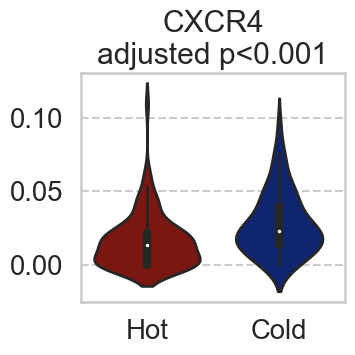

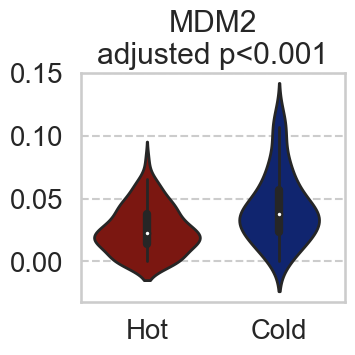

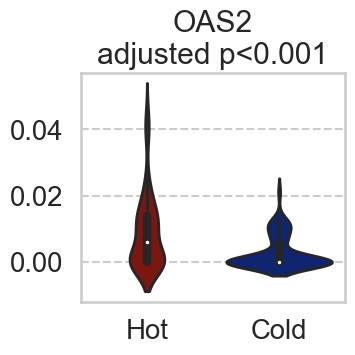

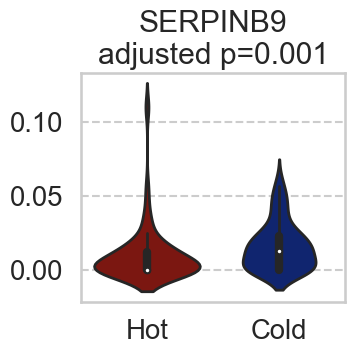

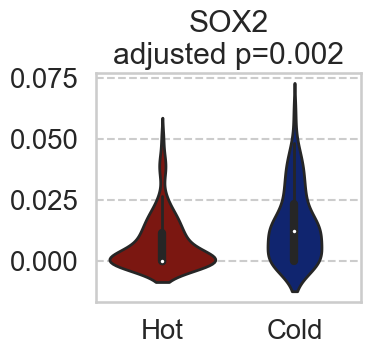

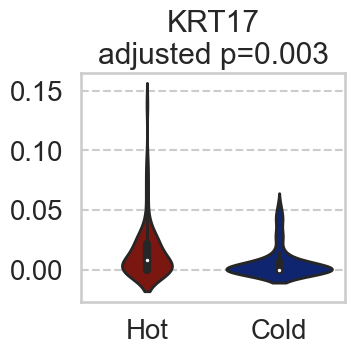

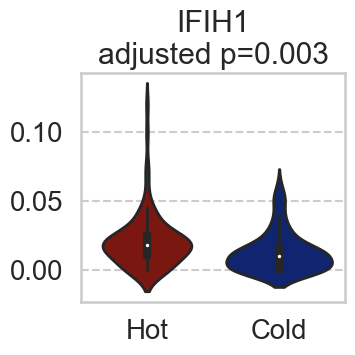

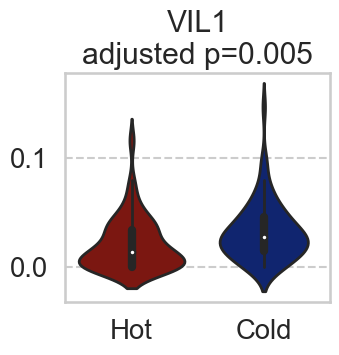

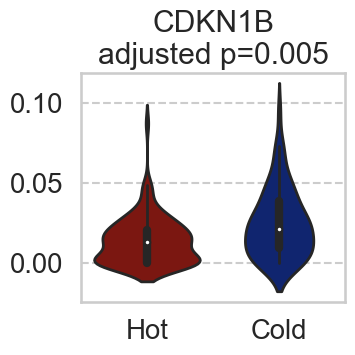

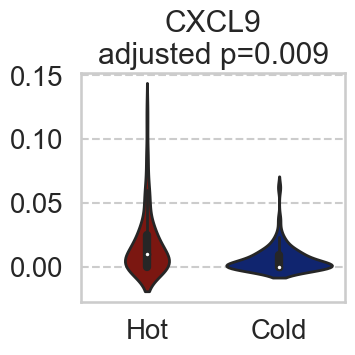

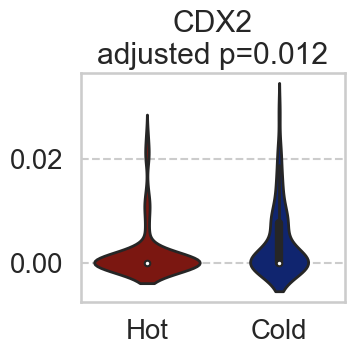

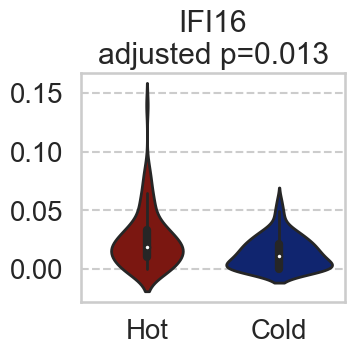

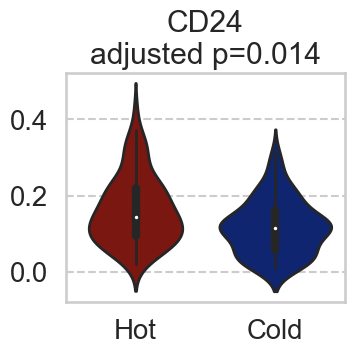

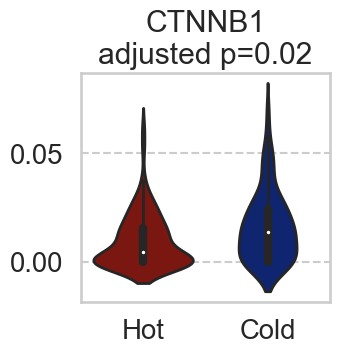

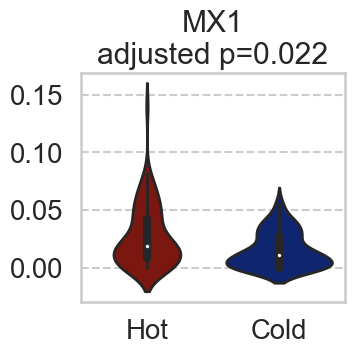

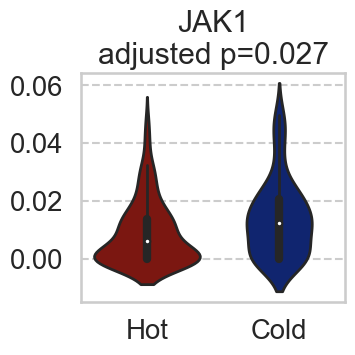

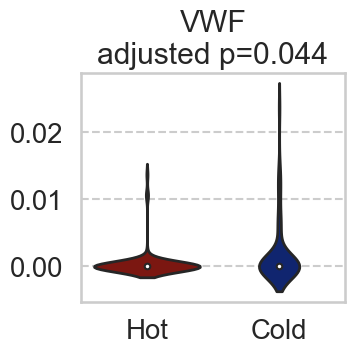

In [10]:
res_ls = []

for i in df_hot_cold.index:
    A = df_hot_cold.loc[i][:100]
    B = df_hot_cold.loc[i][101:]
    
    res_ls += [stats.mannwhitneyu(A,B,alternative='two-sided').pvalue]
    #res_ls += [stats.ttest_ind(A, B, equal_var=False).pvalue]

#df_res = pd.DataFrame(calculate_q(res_ls), index=df_hot_cold.index)
df_res = pd.DataFrame(res_ls, index=df_hot_cold.index).dropna()
df_res[0] = calculate_q(df_res[0])
df_res.index.name = ""

df_sig = df_hot_cold.loc[
    df_res[df_res[0] < 0.2].sort_values(0).index, :
].T

df_sig["label"] = ["Hot"] * len(df_dens_hot.columns) + ["Cold"] * len(df_dens_cold.columns)


sns.set('talk', 'whitegrid', 'dark', font_scale=1.2,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

my_pal = {"Hot": "r", "Cold": "b"}

#os.mkdir("20231013_cold_vs_hot")

for i, s in zip(df_res[df_res[0] < 0.05].sort_values(0).index, df_res[df_res[0] < 0.05].sort_values(0)[0].values):
    #plt.ylim(-0.4, 1.4)
    plt.figure(figsize=(4, 4))
    g = sns.violinplot(x=df_sig["label"].tolist(), 
                       y=df_sig[i].tolist(), 
                      order=["Hot", "Cold"], palette=my_pal)

    
    plt.title(i+"\nadjusted p="+
        str(s.round(3)) if not s < 0.001 else i + "\nadjusted p<0.001"
    )
    plt.tight_layout()
    plt.savefig(f"20231013_cold_vs_hot/{i}.png", dpi=500)

In [ ]:
col_name = f"Case 7, Hot: {len(df_hot)} cells, Cold: {len(df_cold)} cells"

df_res.columns = [
    col_name
]

df_res[col_name] = ["<0.001" if i<0.001 else str(round(i, 3)) for i in df_res[col_name]]

In [38]:
# save
df_res.to_csv("hot_cold_pvalues_case7.txt", sep="\t")